In [1]:
# Imports
import pandas as pd
import os
import csv
import spacy
import time
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data processing

In [2]:

"""
The corpus is formatted as a CSV and contains the following fields:

    id
    domain
    type
    url
    content
    scraped_at
    inserted_at
    updated_at
    title
    authors
    keywords
    meta_keywords
    meta_description
    tags
    summary
    source (opensources, nytimes, or webhose)
"""
csv.field_size_limit(100000000)

filepath = "dataset/news_cleaned_2018_02_13.csv"
selected_columns = ["domain", "title", "authors", "type", "content", "url"]

chunks = []
for chunk in pd.read_csv(filepath, usecols=selected_columns, chunksize=100000, on_bad_lines='warn', engine='python'):
    sample = chunk.sample(frac=0.1, random_state=42)
    chunks.append(sample)

df = pd.concat(chunks, ignore_index=True)
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, random_state=42) # 80% for training and temp for validation and testing
validation_dataframe, test_dataframe = train_test_split(temp_dataframe, test_size=0.5, random_state=42) # splitting the temp data into 10% for validation and 10% for testing

train_dataframe.to_csv("dataset/train_data_final.csv", chunksize=100000)
validation_dataframe.to_csv("dataset/validation_data_final.csv", chunksize=100000)
test_dataframe.to_csv("dataset/test_data_final.csv", chunksize=100000)


In [3]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"]) # https://www.geeksforgeeks.org/tokenization-using-spacy-library/
output_file = "processed_data_final.txt"
selected_columns = ["domain", "title", "authors", "type", "content", "url"]

# counter info https://www.geeksforgeeks.org/python-counter-objects-elements/
lemmatized_vocab_counter = Counter() # number of lemmatized words without stopwords 
stopword_counter = Counter() 
filtered_vocab_counter = Counter() # number of words without stopwords
original_vocab = set()

# I used chatgpt here for understanding how to use spacy and processing the texts in batches
# spacy docs: https://spacy.io/usage/processing-pipelines 
def preprocess(texts):
    for doc in nlp.pipe(texts, batch_size=500, n_process=6): # batch size is the number of texts to process at once

        for token in doc: # token is a single word/punctuation in a list of tokens
            if token.is_alpha: # check if token is a word
                original_vocab.add(token.text.lower())
                word = token.text.lower()
                if (token.is_stop): # if the token is a stopwword, add to counter
                    stopword_counter[word] += 1
                else: # otherwise update the filtered vocab counter and lemmatized vocab counter
                    filtered_vocab_counter[word] += 1
                    lemmatized_vocab_counter[token.lemma_.lower()] += 1 
        
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

input_files = ["dataset/train_data_final.csv", "dataset/validation_data_final.csv", "dataset/test_data_final.csv"]
output_files = ["dataset/processed_train_final.csv", "dataset/processed_validation_final.csv", "dataset/processed_test_final.csv"]

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True

    # writing the processed text data into another file
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging

            # adding label column which tells whether the article is reliable (=1) or not (=0)
            chunk["label"] = chunk["type"].apply(lambda x: 1 if str(x).strip().lower() == "reliable" else 0)
            # collecting yields into a list
            texts = chunk["content"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk

            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["processed_text", "label", "type", "domain", "title", "url", "authors"]].to_csv(f_out, mode="a", header=first_chunk, index=False) 
            first_chunk = False # for the header 


print("Preprocessing done.")

Processing dataset/train_data_final.csv
Chunk processed in 39.50s
Chunk processed in 28.12s
Chunk processed in 26.91s
Chunk processed in 24.77s
Chunk processed in 26.81s
Chunk processed in 27.45s
Chunk processed in 28.20s
Chunk processed in 27.91s
Chunk processed in 28.04s
Chunk processed in 27.05s
Chunk processed in 30.54s
Chunk processed in 27.93s
Chunk processed in 31.02s
Chunk processed in 28.74s
Chunk processed in 28.36s
Chunk processed in 26.77s
Chunk processed in 28.02s
Chunk processed in 28.50s
Chunk processed in 29.78s
Chunk processed in 28.43s
Chunk processed in 29.82s
Chunk processed in 28.96s
Chunk processed in 28.97s
Chunk processed in 30.13s
Chunk processed in 30.82s
Chunk processed in 29.34s
Chunk processed in 31.04s
Chunk processed in 28.36s
Chunk processed in 29.39s
Chunk processed in 31.06s
Chunk processed in 30.62s
Chunk processed in 28.31s
Chunk processed in 31.18s
Chunk processed in 30.25s
Chunk processed in 29.33s
Chunk processed in 29.59s
Chunk processed in 30.99

In [4]:
df_train = pd.read_csv("dataset/processed_train_final.csv")  
df_valid = pd.read_csv("dataset/processed_validation_final.csv")
df_test = pd.read_csv("dataset/processed_test_final.csv")

### Computing reduction rates

In [5]:

stats_path = "dataset/preprocessing_stats_final.txt"

if os.path.exists(stats_path):
    print("Preprocessing stats already exist, reading from file\n")
    with open(stats_path, "r", encoding="utf-8") as f:
        print(f.read())
else: 
    original_vocab_size = len(original_vocab) 
    filtered_vocab_size = len(filtered_vocab_counter)
    lemmatized_vocab_size = len(lemmatized_vocab_counter)

    # reduction rate after stopword removal
    stopword_reduction_rate = ((original_vocab_size - filtered_vocab_size) / original_vocab_size) * 100

    # calculating elmamtized reduction rate
    lemmatized_reduction_rate = ((filtered_vocab_size - lemmatized_vocab_size) / filtered_vocab_size) * 100

    print(f"Original vocabulary size: {original_vocab_size}")
    print(f"Vocabulary size after removing stopwords: {filtered_vocab_size}")
    print(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}")
    print(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%")
    print(f"lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%")

    with open("dataset/preprocessing_stats.txt", "w", encoding="utf-8") as f:
        f.write(f"Original vocabulary size: {original_vocab_size}\n")
        f.write(f"Vocabulary size after removing stopwords: {filtered_vocab_size}\n")
        f.write(f"Vocabulary size after lemmatization: {lemmatized_vocab_size}\n")
        f.write(f"Stopword reduction rate: {stopword_reduction_rate:.2f}%\n")
        f.write(f"Lemmatized reduction rate: {lemmatized_reduction_rate:.2f}%\n")

    print(df_train.head()) 



Original vocabulary size: 1107067
Vocabulary size after removing stopwords: 1106762
Vocabulary size after lemmatization: 1085243
Stopword reduction rate: 0.03%
lemmatized reduction rate: 1.94%
                                      processed_text  label       type  \
0  times cover widely regard major american fashi...      1   reliable   
1  dear reader excited announce voice russia chan...      0       bias   
2     late deliver daily friend think read newspaper      0  political   
3  receive natural health newsletter free subscri...      0    junksci   
4  break tradition budget year yes go deliver fal...      0     satire   

            domain                                              title  \
0      nytimes.com  Gösta Peterson, Barrier-Breaking Fashion Photo...   
1  sputniknews.com  austerity, 2013 : The Voice of Russia: News, B...   
2      pjmedia.com  'Hell or High Water' Is A Pro-Second Amendment...   
3  naturalnews.com  antidepressants articles and information on th... 

### Exploring train data (task 2)

In [6]:
from wordcloud import WordCloud

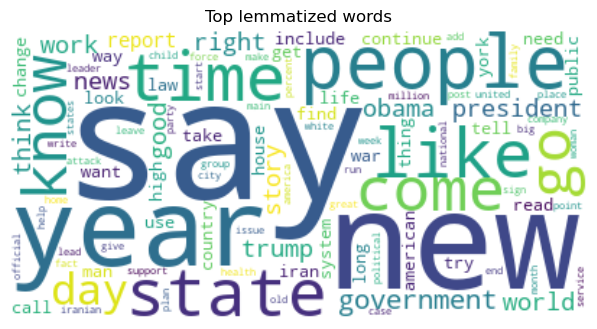

In [7]:
common_word_lemmatized = lemmatized_vocab_counter.most_common(100)

lemmatized_wordcloud = WordCloud(background_color="white").generate_from_frequencies(dict(common_word_lemmatized))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
plt.imshow(lemmatized_wordcloud, interpolation='bilinear')
plt.title("Top lemmatized words")
plt.axis("off")

plt.tight_layout()
plt.show()


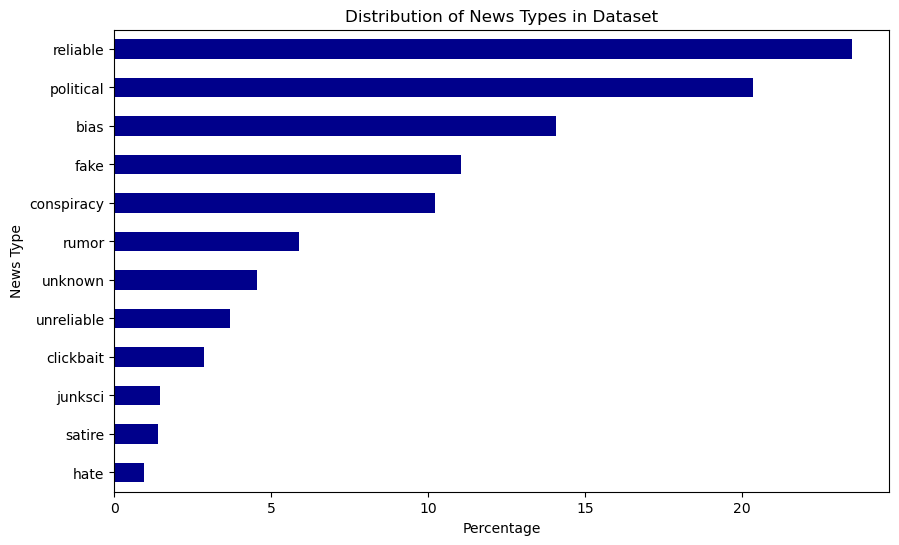

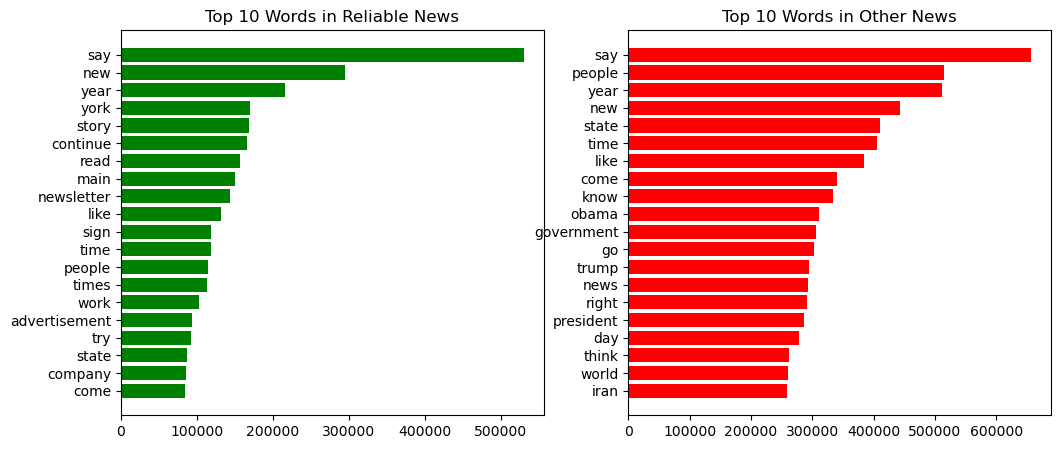

In [8]:
   
# Precentage distribution of labels in the dataset
type_distribution = df_train["type"].value_counts(normalize=True) * 100 # counting the distribution
type_distribution.sort_values().plot(kind="barh", figsize=(10, 6), color="darkblue") # plotting a horizontal bar

plt.xlabel("Percentage")
plt.ylabel("News Type")
plt.title("Distribution of News Types in Dataset")
plt.show()

# visualizing the distribution of words in reliable vs non-reliable news
reliable_texts = df_train[df_train["label"] == 1]["processed_text"].dropna().astype(str)
other_texts = df_train[df_train["label"] != 1]["processed_text"].dropna().astype(str)

reliable_counter = Counter(" ".join(reliable_texts).split())
other_counter = Counter(" ".join(other_texts).split())

# counting the top 10 words in reliable and other news
reliable_top10 = reliable_counter.most_common(20)
other_top10 = other_counter.most_common(20)

# unzipping the word and count pairs
words_r, counts_r = zip(*reliable_top10) # https://www.w3schools.com/python/ref_func_zip.asp
words_o, counts_o = zip(*other_top10)

plt.figure(figsize=(12, 5))

# Plot reliable
plt.subplot(1, 2, 1)
plt.barh(words_r[::-1], counts_r[::-1], color="green")
plt.title("Top 10 Words in Reliable News")

# Plot other
plt.subplot(1, 2, 2)
plt.barh(words_o[::-1], counts_o[::-1], color="red")
plt.title("Top 10 Words in Other News")

plt.show()

# Avanced model

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

### Training the LSTM model

In [10]:
x_train = df_train["processed_text"].fillna("").astype(str).tolist()
y_train = df_train["label"].values

MAX_WORDS=10000
MAX_LEN=100
LSTM_UNITS=64
NUM_CLASSES=1 # 1 class bc its binary classification

# reference: https://spotintelligence.com/2023/01/11/lstm-in-nlp-tasks/
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

# padding sequences make all sequences the same length
xTrain = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')



In [11]:
# Building the model
model = Sequential()
model.add(Embedding(MAX_WORDS, 32))
model.add(LSTM(LSTM_UNITS))
model.add(Dense(NUM_CLASSES, activation='sigmoid'))

In [12]:
# Compiling model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
# training the model
model.fit(xTrain, y_train, batch_size=32, epochs=10)

Epoch 1/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 466s 22ms/step - accuracy: 0.8932 - loss: 0.2637
Epoch 2/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 481s 23ms/step - accuracy: 0.9499 - loss: 0.1299
Epoch 3/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 488s 23ms/step - accuracy: 0.9587 - loss: 0.1081
Epoch 4/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 492s 23ms/step - accuracy: 0.9661 - loss: 0.0905
Epoch 5/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 498s 23ms/step - accuracy: 0.9715 - loss: 0.0767
Epoch 6/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 522s 24ms/step - accuracy: 0.9773 - loss: 0.0622
Epoch 7/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 557s 26ms/step - accuracy: 0.9822 - loss: 0.0506
Epoch 8/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 566s 27ms/step - accuracy: 0.9861 - loss: 0.0408
Epoch 9/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 582s 27ms/step - accuracy: 0.9891 - loss: 0.0325
Epoch 10/10
21323/21323 ━━━━━━━━━━━━━━━━━━━━ 592s 28ms/step - accuracy: 0.9914 - loss: 0.0262


### Validating

In [14]:
x_valid = df_test["processed_text"].fillna("").astype(str).tolist()
y_valid = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_valid)
# padding sequences make all sequences the same length
xValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs = model.predict(xValid)
y_pred = (y_pred_probs >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_valid, y_pred))

print("Accuracy:", accuracy_score(y_valid, y_pred))
print("Precision:", precision_score(y_valid, y_pred))
print("Recall:", recall_score(y_valid, y_pred))
print("F1-score:", f1_score(y_valid, y_pred))


2666/2666 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96     66171
           1       0.89      0.85      0.87     19120

    accuracy                           0.94     85291
   macro avg       0.92      0.91      0.92     85291
weighted avg       0.94      0.94      0.94     85291

Accuracy: 0.9427489418578748
Precision: 0.8866858601770873
Recall: 0.8537133891213389
F1-score: 0.8698872871645927


### Evaluating the model

In [15]:
x_test = df_test["processed_text"].fillna("").astype(str).tolist()
y_test = df_test["label"].values

sequences = tokenizer.texts_to_sequences(x_test)

# padding sequences make all sequences the same length
xTest = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

loss, accuracy = model.evaluate(xTest, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

2666/2666 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9423 - loss: 0.2465
Test Loss: 0.2406
Test Accuracy: 0.9427


# Validating with LIAR

## Preprocess LIAR dataset

In [16]:
liar_test_filepath = "dataset/liar/test.tsv"
liar_valid_filepath = "dataset/liar/valid.tsv"

# convert liar data to csv
# liar headers
liar_headers= ["id", "label", "statement", "subject", "speaker", "job_title", "state_info", "party_affiliation",
                "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_onfire_counts", "context"]
# convert liar data to csv
liar_test_df = pd.read_csv(liar_test_filepath, sep="\t", header=None, names=liar_headers)
liar_valid_df = pd.read_csv(liar_valid_filepath, sep="\t", header=None, names=liar_headers)

# check distribution of labels
label_distribution_test = liar_test_df["label"].value_counts(normalize=True) * 100 # counting the distribution
label_distribution_valid = liar_valid_df["label"].value_counts(normalize=True) * 100 # counting the distribution
print(f"Label distribution in liar test set: {label_distribution_test}")
print(f"Label distribution in liar validation set: {label_distribution_valid}")

liar_test_df.to_csv("dataset/liar/test.csv", index=False)
liar_valid_df.to_csv("dataset/liar/valid.csv", index=False)

# labels in liar = true, false, half-true, pants-fire, barely-true, mostly-true
# only true and mostly-true are true others are false
# converting labels to binary 1=true, 0=false
liar_selected_columns = ["label", "subject", "statement"]

input_files = ["dataset/liar/test.csv", "dataset/liar/valid.csv"]
output_files = ["dataset/liar/test_processed.csv", "dataset/liar/valid_processed.csv"]

def preprocess_liar(text):
    for doc in nlp.pipe(texts, batch_size=500, n_process=4): # batch size is the number of texts to process at once
        yield " ".join(token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop)

for input_file, output_file in zip(input_files, output_files):
    print(f"Processing {input_file}")
    first_chunk = True
    with open(output_file, "w", encoding="utf-8") as f_out: 
        for chunk in pd.read_csv(input_file, encoding="utf-8", usecols=liar_selected_columns, on_bad_lines='warn', chunksize=1024, engine='python'):
            start = time.time() # timing the chunk processing for debugging
            # adding binar_label column which tells whether the article is reliable (=1) or not (=0)
            chunk["binary_label"] = chunk["label"].apply(lambda x: 1 if str(x).strip().lower() in ["true", "mostly-true"] else 0)
            texts = chunk["statement"].fillna("").astype(str).tolist() # content column to a list
            processed = list(preprocess_liar(texts)) # processing the list
            chunk["processed_text"] = processed # assigning back to chunk
            print(f"Chunk processed in {time.time() - start:.2f}s")
            # appending the chunk to the output file
            chunk[["binary_label", "label", "subject", "processed_text"]].to_csv(f_out, mode="a", header=first_chunk, index=False)
            first_chunk = False # for the header
    
# check distribution of labels
liar_df_valid = pd.read_csv("dataset/liar/valid_processed.csv")
liar_df_test = pd.read_csv("dataset/liar/test_processed.csv")
label_distribution_test = liar_df_test["binary_label"].value_counts(normalize=True) * 100 # counting the distribution
label_distribution_valid = liar_df_valid["binary_label"].value_counts(normalize=True) * 100 # counting the distribution
print(f"Label distribution in liar test set: {label_distribution_test}")
print(f"Label distribution in liar validation set: {label_distribution_valid}")


Label distribution in liar test set: label
half-true      20.915549
false          19.652723
mostly-true    19.021310
barely-true    16.732439
true           16.416732
pants-fire      7.261247
Name: proportion, dtype: float64
Label distribution in liar validation set: label
false          20.482866
mostly-true    19.548287
half-true      19.314642
barely-true    18.457944
true           13.161994
pants-fire      9.034268
Name: proportion, dtype: float64
Processing dataset/liar/test.csv
Chunk processed in 94.14s
Chunk processed in 77.05s
Processing dataset/liar/valid.csv
Chunk processed in 77.25s
Chunk processed in 76.32s
Label distribution in liar test set: binary_label
0    64.561957
1    35.438043
Name: proportion, dtype: float64
Label distribution in liar validation set: binary_label
0    67.28972
1    32.71028
Name: proportion, dtype: float64


## Evaluate with LIAR

In [17]:
x_liar_valid = liar_df_valid["processed_text"].fillna("").astype(str).tolist()
y_liar_valid = liar_df_valid["binary_label"].values

sequences = tokenizer.texts_to_sequences(x_liar_valid)

# padding sequences make all sequences the same length
xLiarValid = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

# predictions
y_pred_probs_valid = model.predict(xLiarValid)
y_pred_valid = (y_pred_probs_valid >= 0.5).astype(int).flatten() 

# evaluation
print(classification_report(y_liar_valid, y_pred_valid))

loss, accuracy = model.evaluate(xLiarValid, y_liar_valid)
print(f"LIAR Test Loss: {loss:.4f}")
print(f"LIAR Test Accuracy: {accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.68      0.97      0.80       864
           1       0.45      0.04      0.08       420

    accuracy                           0.67      1284
   macro avg       0.56      0.51      0.44      1284
weighted avg       0.60      0.67      0.56      1284

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6790 - loss: 2.0221
LIAR Test Loss: 2.1148
LIAR Test Accuracy: 0.6698
